In [1]:
import sys
# sys.path.append("C:\\Users\\infinigru\\Anaconda3\\envs\\prac\\lib\\site-packages")
import os
import numpy as np
import json
import pandas as pd
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
sys.path = ["C:\\Users\\infinigru\\Anaconda3\\envs\\prac\\lib\\site-packages"] + sys.path

from config import *
from utils.util import *
# from model import *
from iterator import DataIterator

Using TensorFlow backend.


In [2]:
hist = pd.read_csv(os.path.join(RESULT_PATH,"checkpoint_hist.csv"))

In [3]:
hist.tail()

,epoch,loss,auc,val_loss,val_auc
28,26,1.481791,0.997007,0.211995,0.947917
29,27,1.447524,0.997415,0.205071,0.942986
30,28,1.419774,0.997973,0.212263,0.951458
31,29,1.396207,0.998300,0.196270,0.952222
32,30,1.373080,0.998483,0.221934,0.940069


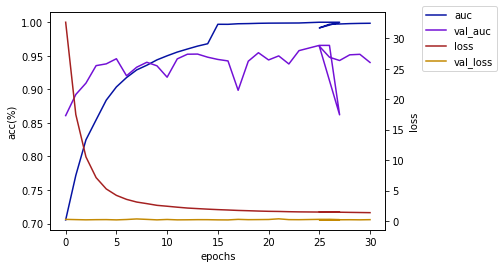

In [4]:
history_graph(hist,metics='auc')

In [5]:
## train 했을때의 옵션
with open(os.path.join(RESULT_PATH,'train_options.json'), 'r') as f:
    train_options = json.loads(f.read())

In [6]:
augm = train_options["augmemtation"]

In [7]:
# augm = {"gamma":False, "rotate":False, "polar":False, "hiseq":True, "normal":False, "flip":False
#         , "copy":True ,"get_roi":True}
## load batch generator
# print(f"\ntrain data from : {TRAIN_DATASET}")
# train_iterator = DataIterator(TRAIN_DATASET, 1, INPUT_IMAGE_SHAPE
#                               , is_train=True
#                               , rotate = augm['rotate'], polar = augm['polar'], hiseq = augm['hiseq'], get_roi = augm["get_roi"]
#                               , gamma = augm['gamma'], flip = augm['flip'], normal = augm['normal'])

print(f"\ntest data from : {TEST_DATASET}")
test_iterator = DataIterator(TEST_DATASET, 1, INPUT_IMAGE_SHAPE
                            , is_train=False, polar= augm['polar'], hiseq = augm['hiseq']
                             , get_roi = True, normal = augm['normal'])


test data from : C:\Projects\my_Glaucoma_project_v2\dataset\test.h5


In [8]:
import json
with open(os.path.join(RESULT_PATH,"model.json"), 'r') as f:
    model_json = json.loads(f.read())

In [9]:
model = keras.models.model_from_json(model_json)

Instructions for updating:
Colocations handled automatically by placer.


## Best epoch : checkpoint-024.h5

In [10]:
# os.path.join(RESULT_PATH,"checkpoint-024.h5")
weight = last_cheackpoint(RESULT_PATH) # os.path.join(SEGMENT_RESULT_PATH,"checkpoint-022.h5")
print(weight)
model.load_weights(weight)

C:\Projects\my_Glaucoma_project_v2\result\checkpoint-024.h5


In [11]:
y_pred = model.predict_generator(test_iterator,
                                 steps=None,
                                 max_queue_size=30,
                                 workers=4,
                                 use_multiprocessing=False,
                                 verbose=1
                                 )

400/400 [==============================] - 229s 574ms/step


In [16]:
y_true = test_iterator.get_label()

In [32]:
conf_mat, sensitivity, specificity = confusion_matrix_report(y_true, y_pred,0.1)
print(conf_mat)
print(f"{sensitivity}")
print(f"{specificity}")

0.1      1,      0
      1     32,     15
      0      8,    345
Sensitivity : 0.8
Specificity : 0.95833


In [29]:
error_df = pd.DataFrame({"Class":y_true.flatten(), "y_pred":y_pred.flatten()})

In [33]:
def visualize_anomaly(error_df, threshold = None):
    """anomaly graph 출력
    
    Arguments:
        error_df {pandas DataFrame} -- Class, y_pred column이 포함된 DataFrame
                clss : label
                y_pred : 예측된 스코어
    
    Keyword Arguments:
        threshold {int} -- 그래프에 출력될 cut off값, 미지정시 상위 0.5% 자동  (default: {None})
    """
    if threshold is None:
        threshold = error_df[error_df['Class'] == 1].y_pred.quantile(q = 0.5) # 95 % higher
        print('Generated threshold : {}'.format(threshold))
        
    fig, ax = plt.subplots(figsize = (10,6))

    for name, group in error_df.groupby('Class'):
        ax.plot(group.index, group['y_pred'], marker = 'o', linestyle = '', alpha = 0.6, 
                label = "Glaucoma" if name == 1 else "Normal",
                color = 'r' if name == 1 else 'royalblue')

    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], 
              colors = 'r', zorder = 100, label = 'Threshold')
    ax.legend()

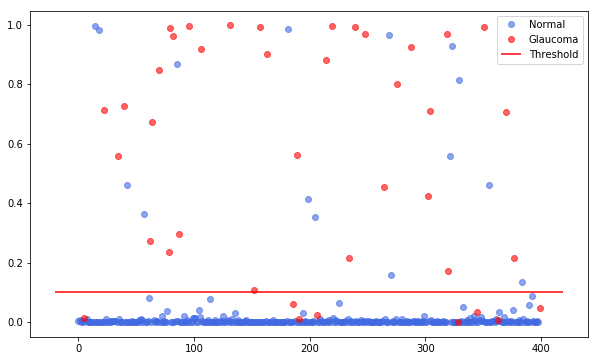

In [34]:
visualize_anomaly(error_df,threshold=0.1)